In [1]:
import os
import sys
import numpy as np


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']
plt.rcParams["font.size"] = 14

import torch
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity as ssim

from tqdm import tqdm

import string

sys.path.append("/home/dp4018/scripts/InverseLDM/")
from invldm.utils.visualisation import OSCAR_CMAP, scale2range

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


# EXP_NAME = "cosmic-cloud-50"
EXP_NAME = "comfy-yogurt-60"
DEVICE = "cuda:0"

In [2]:
def cosine_similarity_loss(x1, x2):
    x1 = x1 / x1.norm(dim=1)
    x2 = x2 / x1.norm(dim=1)
    return (x1 * x2).sum()

In [6]:
exp = torch.load(f"/home/dp4018/scripts/Seismic/exps/{EXP_NAME}/{EXP_NAME}-ckpt.pt", map_location="cpu")
dataset = exp["dataset"]
model = exp["model"].to(DEVICE)
model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

num_samples = len(dataset)
# num_samples = 100


base_image = None
base_stack = None
near_image = None
near_stack = None
middle_image = None
middle_stack = None
far_image = None
far_stack = None 


base_image_embed = None
base_stack_embed = None
near_image_embed = None
near_stack_embed = None
middle_image_embed = None
middle_stack_embed = None
far_image_embed = None
far_stack_embed = None 

highest_loss, lowest_loss = 0., 1.
highest_loss_stack, lowest_loss_stack = 0., 1.
highest_loss_image, lowest_loss_image = 0., 1.

for i in tqdm(range(num_samples)):
    image_path = dataset.data_paths[i]
    image_name = image_path.split("/")[-1].split(".")[0]
    stack_path = os.path.join(dataset.args.condition.path, f"{image_name}-{dataset.args.condition.mode}.npy")

    image, stack = np.load(image_path), np.load(stack_path)

    image_preproc, stack_preproc = dataset[i]
    with torch.no_grad():
        image_embed, stack_embed, logits_image, logits_data = model(image_preproc.unsqueeze(0).to(DEVICE), stack_preproc.unsqueeze(0).to(DEVICE))

    if i == 0:
        base_image = image
        base_stack = stack
        base_image_embed = image_embed
        base_stack_embed = stack_embed
    else:
        loss_stack = abs(((stack_embed - stack_embed.mean()) * (base_stack_embed - base_stack_embed.mean())).sum()).item()
        loss_image = abs(((image_embed - image_embed.mean()) * (base_image_embed - base_image_embed.mean())).sum()).item()
        loss = 0.5*(loss_stack + loss_image)

        if loss < lowest_loss:
            lowest_loss = loss
            lowest_loss_stack = loss_stack
            lowest_loss_image = loss_image
            far_image = image
            far_stack = stack
            far_image_embed = image_embed
            far_stack_embed = stack_embed

        mid_loss = lowest_loss + (highest_loss - lowest_loss)/2
        mid_loss_image = lowest_loss_image + (highest_loss_image - lowest_loss_image)/2
        mid_loss_stack = lowest_loss_stack + (highest_loss_stack - lowest_loss_stack)/2
        if (loss_stack > mid_loss_stack*0.95 and loss_stack < mid_loss_stack*1.05) and (loss_image > mid_loss_image*0.95 and loss_image < mid_loss_image*1.05):
            mid_loss = loss
            mid_loss_stack = loss_stack
            mid_loss_image = loss_image
            middle_image = image
            middle_stack = stack
            middle_image_embed = image_embed
            middle_stack_embed = stack_embed

        if loss > highest_loss:
            highest_loss = loss
            highest_loss_stack = loss_stack
            highest_loss_image = loss_image
            near_image = image
            near_stack = stack
            near_image_embed = image_embed
            near_stack_embed = stack_embed

base_image_embed = base_image_embed.cpu().numpy()
base_stack_embed = base_stack_embed.cpu().numpy()
near_image_embed = near_image_embed.cpu().numpy()
near_stack_embed = near_stack_embed.cpu().numpy()
middle_image_embed = middle_image_embed.cpu().numpy()
middle_stack_embed = middle_stack_embed.cpu().numpy()
far_image_embed = far_image_embed.cpu().numpy()
far_stack_embed = far_stack_embed.cpu().numpy()

print("Lowest Cosine Similarity: ", lowest_loss)
print("Middle Cosine Similarity: ", mid_loss)
print("Highest Cosine Similarity: ", highest_loss)

100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]

Lowest Cosine Similarity:  0.006119828205555677
Middle Cosine Similarity:  0.5012776607181877
Highest Cosine Similarity:  0.9964354932308197


In [7]:
pca = PCA(n_components=2)

images = np.concatenate([base_image, near_image, middle_image, far_image]).reshape(4, 320*320)
images_pca = pca.fit_transform(images / np.abs(np.max(images)))
images = images.reshape(4, 320, 320)

images_embed = np.concatenate([base_image_embed, near_image_embed, middle_image_embed, far_image_embed]).reshape(4, model.visual_image.output_size**2 * model.visual_image.output_dim)
images_embed_pca = pca.fit_transform(images_embed)
images_embed = images_embed.reshape(4, model.visual_image.output_dim, model.visual_image.output_size, model.visual_image.output_size)

stacks = np.concatenate([base_stack, near_stack, middle_stack, far_stack]).reshape(4, stack.shape[0]* stack.shape[1])
stacks_pca = pca.fit_transform(stacks / np.abs(np.max(stacks)))
stacks = stacks.reshape(4, stack.shape[0], stack.shape[1])

stacks_embed = np.concatenate([base_stack_embed, near_stack_embed, middle_stack_embed, far_stack_embed]).reshape(4, model.visual_image.output_size**2 * model.visual_image.output_dim)
stacks_embed_pca = pca.fit_transform(stacks_embed)
stacks_embed = stacks_embed.reshape(4, model.visual_image.output_dim, model.visual_image.output_size, model.visual_image.output_size)

imgs_avg_rel_error = [abs(((img - base_image) / base_image).mean())*100 for img in images]
imgs_cos_sim =[1., highest_loss_image, mid_loss_image, lowest_loss_image]
imgs_ssim = [ssim(scale2range(base_image[0]/3000., [0, 1]), scale2range(img/3000., [0, 1]), gaussian_weights=True, sigma=1.5, data_range=1.) for img in images]


# stacks_avg_rel_error = [abs(((stack/np.max(np.abs(stack)) - base_stack/np.max(np.abs(base_stack))) / (base_stack/np.max(np.abs(base_stack)) + 1e-8)).mean())*100 for stack in stacks]
stacks_avg_rel_error = [abs(((stack - base_stack) / (base_stack/np.max(np.abs(base_stack)) + 1e-8)).mean())*100 for stack in stacks]
stacks_cos_sim =[1., highest_loss_stack, mid_loss_stack, lowest_loss_stack]

print(images_pca.shape, images_embed_pca.shape, stacks_pca.shape, stacks_embed_pca.shape)

(4, 2) (4, 2) (4, 2) (4, 2)


In [9]:
print(imgs_ssim)

[1.0, 0.6693183329342228, 0.5789611617897594, 0.6174808101730888]


/tmp/ipykernel_902154/2517909227.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, 1].scatter(images_pca[i, 0], images_pca[i, 1], c=colours[i], s=180., linewidth=0.5, edgecolor='k')
/tmp/ipykernel_902154/2517909227.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, 1].scatter(stacks_pca[i, 0], stacks_pca[i, 1], marker="*", c=colours[i], s=180., linewidth=0.5, edgecolor='k')
/tmp/ipykernel_902154/2517909227

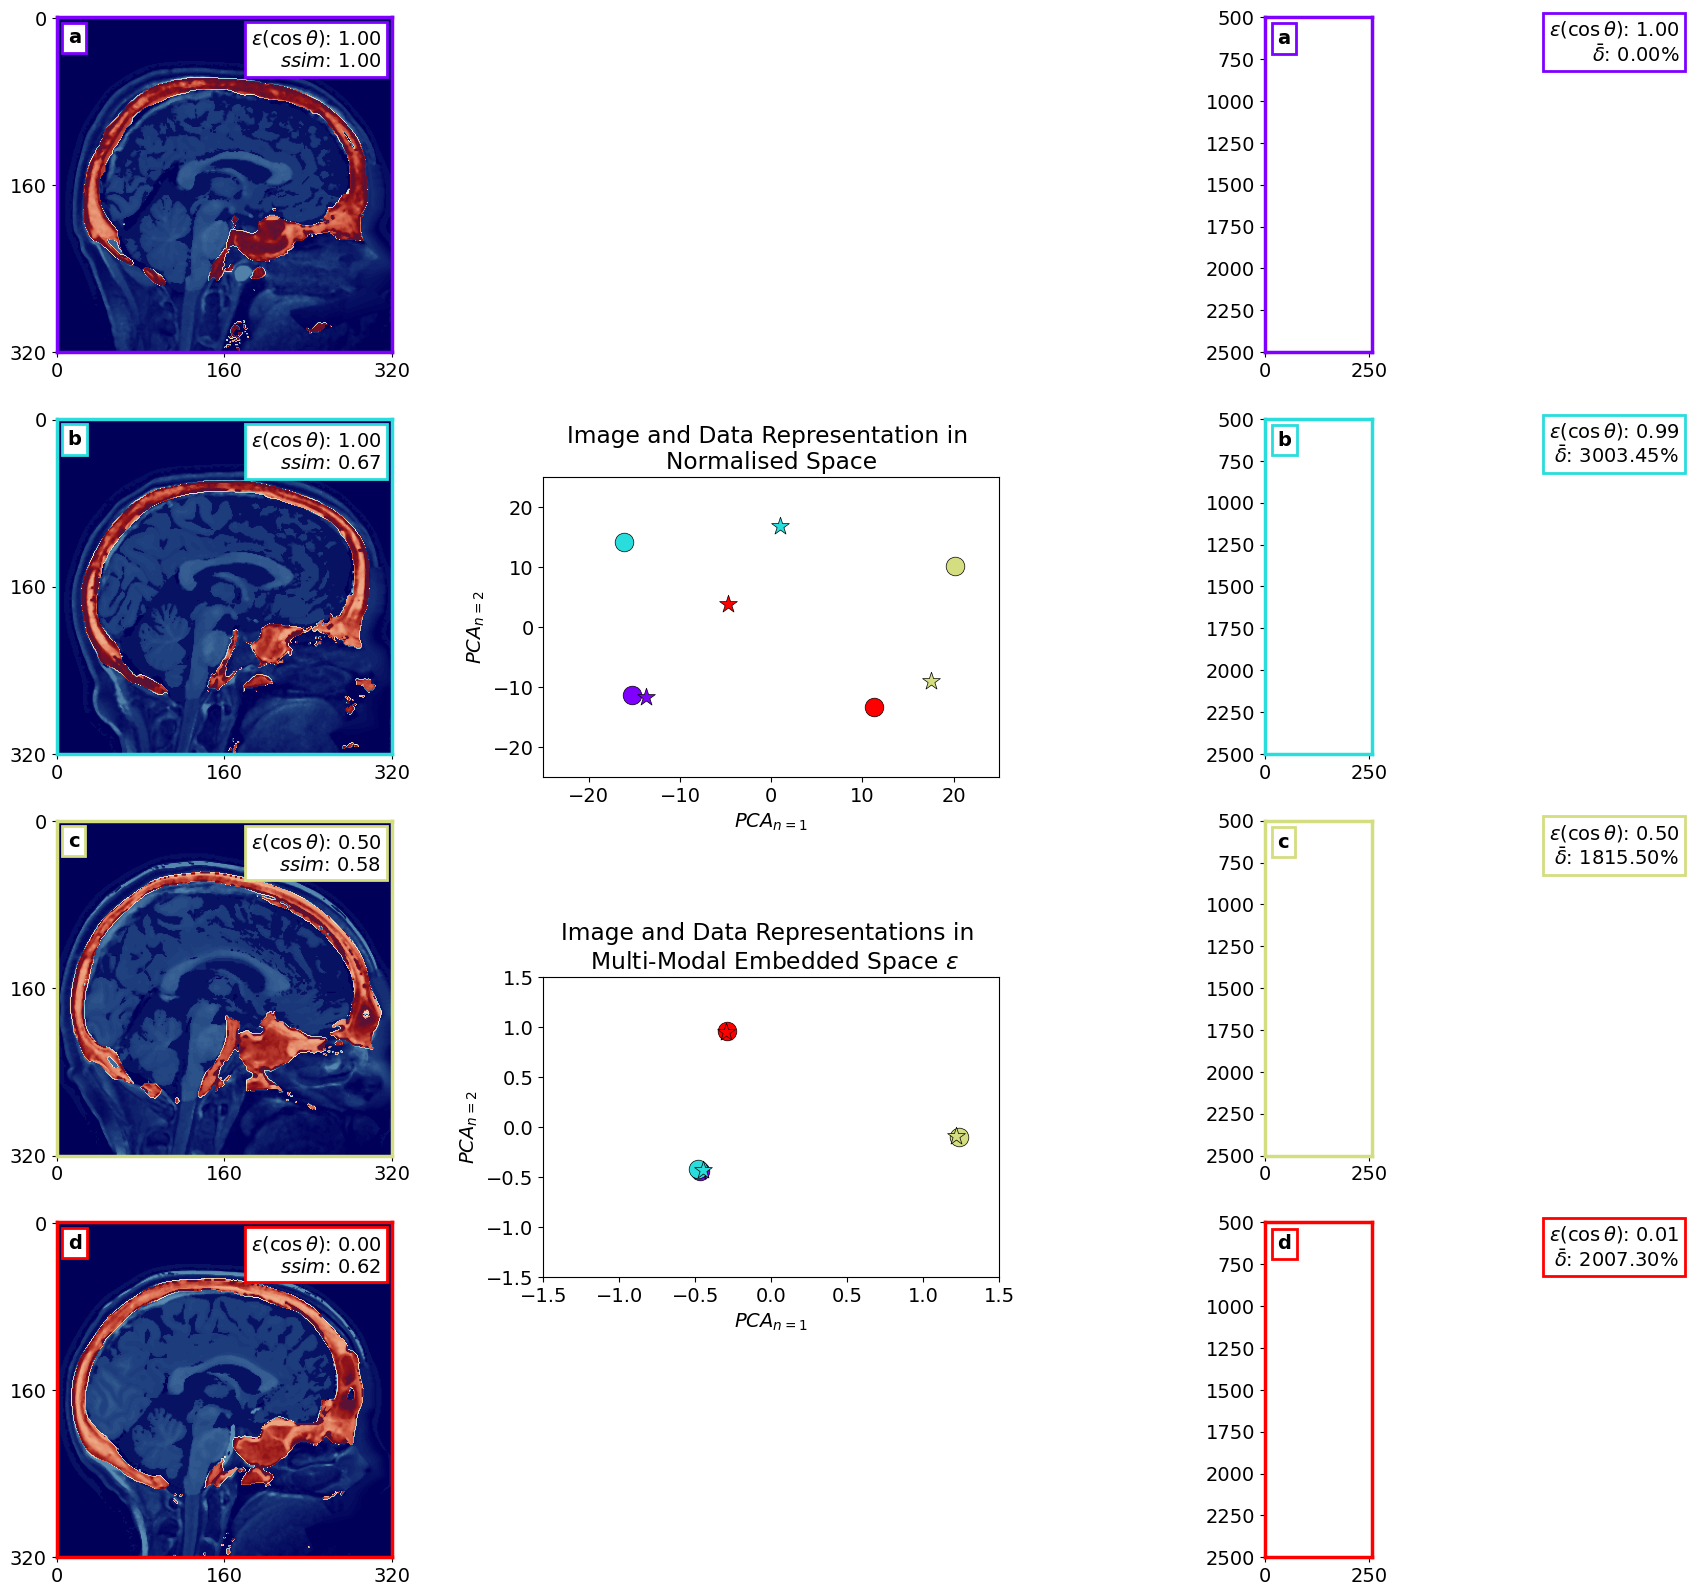

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(20,20))

pos = axs[0, 1].get_position()
pos.y0 = 0.5
pos.y1 = 0.65
axs[0, 1].set_position(pos)
axs[1, 1].remove()

pos = axs[2, 1].get_position()
pos.y0 = 0.25
pos.y1 = 0.4
axs[2, 1].set_position(pos)
axs[3, 1].remove()

letters = list(string.ascii_lowercase)
colours = ["gray", "green", "purple", "blue"]
colours = mpl.colormaps['rainbow'](np.linspace(0, 1, 4))

for i in range(4):

    # Images
    axs[i][0].imshow(np.rot90(images[i]), cmap=OSCAR_CMAP)
    for spine in axs[i][0].spines.values():
        spine.set_edgecolor(colours[i])
        spine.set_linewidth(2.5)
    
    bbox_dict = dict(edgecolor=colours[i], fill=True, facecolor="white", linewidth=2.)
    axs[i, 0].text(310, 10, r'$\epsilon(\cos{\theta})$' + f': {imgs_cos_sim[i]:.2f}'+'\n'+ r'$ssim$' + f': {imgs_ssim[i]:.2f}', ha='right', va='top', bbox=bbox_dict)
    axs[i, 0].text(10, 10, f'{letters[i]}', ha='left', va='top', fontweight="bold", bbox=bbox_dict)
    axs[i, 0].set_yticks([0, 160, 320])
    axs[i, 0].set_xticks([0, 160, 320])
    

    # PCAs
    axs[0, 1].scatter(images_pca[i, 0], images_pca[i, 1], c=colours[i], s=180., linewidth=0.5, edgecolor='k')
    axs[0, 1].scatter(stacks_pca[i, 0], stacks_pca[i, 1], marker="*", c=colours[i], s=180., linewidth=0.5, edgecolor='k')
    axs[0, 1].set_title("Image and Data Representation in \nNormalised Space")
    axs[0, 1].set_xlabel(r"$PCA_{n=1}$")
    axs[0, 1].set_ylabel(r"$PCA_{n=2}$")
    axs[0, 1].set_xlim(-25, 25)
    axs[0, 1].set_ylim(-25, 25)
    

    axs[2, 1].scatter(images_embed_pca[i, 0], images_embed_pca[i, 1], c=colours[i], s=180., linewidth=0.5, edgecolor='k')
    axs[2, 1].scatter(stacks_embed_pca[i, 0], stacks_embed_pca[i, 1], marker="*", c=colours[i], s=180., linewidth=0.5, edgecolor='k')
    axs[2, 1].set_title("Image and Data Representations in \n Multi-Modal Embedded Space " + r"$\epsilon$")
    axs[2, 1].set_xlabel(r"$PCA_{n=1}$")
    axs[2, 1].set_ylabel(r"$PCA_{n=2}$")
    axs[2, 1].set_xlim(-1.5, 1.5)
    axs[2, 1].set_ylim(-1.5, 1.5)
    
    # Stacks
    # stk = scale2range(stacks[i], [-1, 1])
    axs[i][2].imshow(stacks[i].T / np.abs(np.max(stacks[i])), cmap="seismic", aspect=0.4)#, vmin=-0.05, vmax=0.05, interpolation="antialiased")
    axs[i][2].set_ylim(2500, 500)
    # axs[i, 2].set_yticks([0, 1250, 2500])
    # axs[i, 2].set_xticks([0, 160, 320])
    for spine in axs[i][2].spines.values():
        spine.set_edgecolor(colours[i])
        spine.set_linewidth(2.5)

    axs[i, 2].text(990, 510, r'$\epsilon(\cos{\theta})$' + f': {stacks_cos_sim[i]:.2f}'+'\n'+ r'$\bar{\delta}$' + f': {stacks_avg_rel_error[i]:.2f}%', ha='right', va='top', bbox=bbox_dict)
    axs[i, 2].text(30, 570, f'{letters[i]}', ha='left', va='top', fontweight="bold", bbox=bbox_dict)

plt.show()

In [9]:
num_samples=50
all_logits_image = np.zeros((num_samples, num_samples))
all_logits_data = np.zeros((num_samples, num_samples))

for i in tqdm(range(num_samples)):
    image_preproc_A, stack_preproc_A = dataset[i]

    for j in range(i, num_samples):
        image_preproc_B, stack_preproc_B = dataset[j]
        image_in = torch.concat([image_preproc_A.unsqueeze(0), image_preproc_B.unsqueeze(0)])
        stack_in = torch.concat([stack_preproc_A.unsqueeze(0), stack_preproc_B.unsqueeze(0)])

        with torch.no_grad():
            _, _, logits_image, logits_data = model(image_in.to(DEVICE), stack_in.to(DEVICE))

        all_logits_image[i, j] = logits_image[1, 0]
        all_logits_image[j, i] = logits_image[0, 1]

        all_logits_data[i, j] = logits_data[1, 0]
        all_logits_data[j, i] = logits_data[0, 1]
        

100%|██████████| 50/50 [05:44<00:00,  6.88s/it]


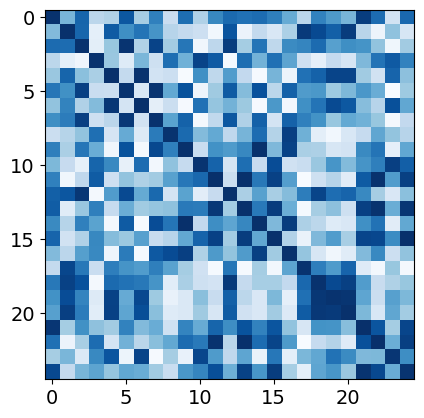

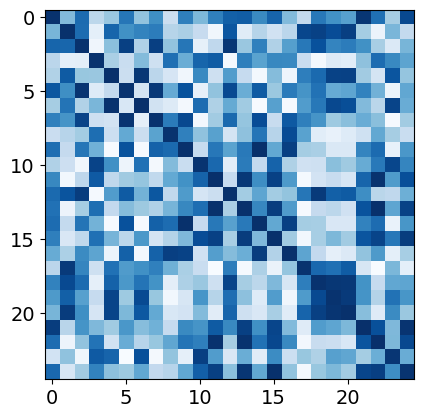

In [8]:
plt.imshow(all_logits_image, cmap="Blues");plt.show()

plt.imshow(all_logits_data, cmap="Blues");plt.show()